<a href="https://colab.research.google.com/github/dangcaptkd/temp1/blob/master/Fruit_recognition_using_color_extraction3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
import pandas as pd

In [38]:
def clustering_image(img):
  #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  vectorized = img.reshape((-1,3))
  vectorized = np.float32(vectorized)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  attempts=10
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((img.shape))
  return result_image, center

In [39]:
def remove_light_color(img, center_color):
  light_color = max(sum(center_color[0]), sum(center_color[1]))
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      if sum(img[x][y]) == light_color:
        img[x][y][0]=0
        img[x][y][1]=0
        img[x][y][2]=0
  return img

done 10 image


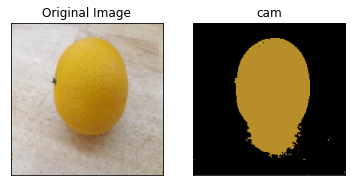

done 20 image


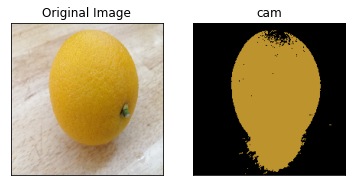

done 30 image


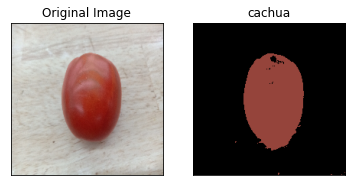

done 40 image


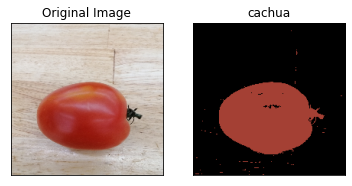

done 50 image


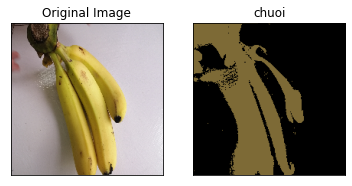

done 60 image


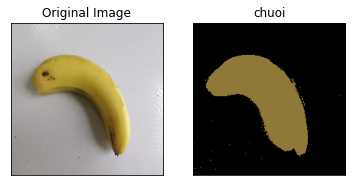

In [40]:
path = '/content/drive/My Drive/học kì 4 uit/Fruit_60_imgs'
folder_name = os.listdir(path)
dataset_train = {}
dataset_test = {}
test_size = 0.25
number = 1
dim = (200, 200)
for name in folder_name:
  images_train = []
  images_test = []
  for img in os.listdir(path+'/'+name):
    fruit_img = cv2.imread(path+'/'+name+'/'+img)
    fruit_img = cv2.resize(fruit_img, dim)
    fruit_img = cv2.cvtColor(fruit_img,cv2.COLOR_BGR2RGB)

    cluster_img, center_color= clustering_image(fruit_img)

    cluster_img = remove_light_color(cluster_img, center_color)
    
    if len(images_test) < test_size*(len(os.listdir(path+'/'+name))):
      images_test.append(cluster_img)
    else:
      images_train.append(cluster_img)
    #cv2_imshow(rb_img)
    if number%10==0:
      print('done {} image'.format(number))
      figure_size = 6
      plt.figure(figsize=(figure_size,figure_size))

      plt.subplot(1,2,1),plt.imshow(fruit_img)
      plt.title('Original Image'), plt.xticks([]), plt.yticks([])

      plt.subplot(1,2,2),plt.imshow(cluster_img)
      plt.title(name), plt.xticks([]), plt.yticks([])

     
      plt.show()

    number+=1
  dataset_train[name] = images_train
  dataset_test[name] = images_test

In [41]:
def features_grid(img):
    features = np.array([], dtype='uint8')
    section = 1
    
    for y in range(0, img.shape[0], 40):
        for x in range(0, img.shape[1], 40):

            # Cropping the image into a section.
            section_img = img[y:y+40, x:x+40]
            
            # Claculating the mean and stdev of the sectioned image.
            section_mean = np.mean(section_img)
            section_std = np.std(section_img)
            
            # Appending the above calculated values into features array.
            features = np.append(features, [section_mean, section_std])
    
    # Returning the features array.
    return features

In [42]:
feature_names = []
section = 1
    
for y in range(0, 200, 40):
    for x in range(0, 200, 40):
        feature_names.append(f"sec{section}_mean")
        feature_names.append(f"sec{section}_std")
        section += 1

In [43]:
def create_df_with_many_imgs(dataset):
  all_imgs = np.zeros((1, 50), dtype='uint8')
  name_fruits = []
  #all_imgs = np.append(all_imgs, img_features, axis=0)
  for name in dataset:
    for img in dataset[name]:
      name_fruits.append(name)
      img_features = features_grid(img)
      
      img_features = img_features.reshape(1, img_features.shape[0])

      all_imgs = np.append(all_imgs, img_features, axis=0)

  all_imgs = all_imgs[1:]

  df = pd.DataFrame(all_imgs, columns=feature_names)
  df.insert(loc=0, column="name", value=name_fruits)
  return df

In [44]:
df_train = create_df_with_many_imgs(dataset_train)
df_test = create_df_with_many_imgs(dataset_test)

In [45]:
df_test.head()

,name,sec1_mean,sec1_std,sec2_mean,sec2_std,sec3_mean,sec3_std,sec4_mean,sec4_std,sec5_mean,sec5_std,sec6_mean,sec6_std,sec7_mean,sec7_std,sec8_mean,sec8_std,sec9_mean,sec9_std,sec10_mean,sec10_std,sec11_mean,sec11_std,sec12_mean,sec12_std,sec13_mean,sec13_std,sec14_mean,sec14_std,sec15_mean,sec15_std,sec16_mean,sec16_std,sec17_mean,sec17_std,sec18_mean,sec18_std,sec19_mean,sec19_std,sec20_mean,sec20_std,sec21_mean,sec21_std,sec22_mean,sec22_std,sec23_mean,sec23_std,sec24_mean,sec24_std,sec25_mean,sec25_std
0,cam,0.000000,0.000000,6.432500,30.534428,52.467500,72.038183,19.220000,50.398858,0.000,0.000000,0.155,4.841416,86.180000,74.957461,118.420000,62.471516,103.617500,70.346656,0.155000,4.841416,0.000000,0.000000,105.942500,69.378491,124.000000,58.263768,106.175000,69.276639,4.107500,24.594853,0.000000,0.000000,64.712500,74.888143,124.000000,58.263768,78.817500,75.623453,0.077500,3.424275,1.007500,12.308396,4.495,25.694973,48.360000,70.582366,4.417500,25.479221,0.387500,7.649064
1,cam,0.000000,0.000000,0.079583,3.520819,48.147917,72.008962,37.642917,66.703773,0.000,0.000000,0.000,0.000000,35.812500,65.563632,124.309167,62.609393,122.160417,64.145694,18.702083,50.644048,0.000000,0.000000,60.562917,75.963383,118.022083,66.810892,127.253750,60.316504,35.732917,65.512450,0.000000,0.000000,27.535833,59.439405,125.264167,61.890416,117.942500,66.858595,8.037917,34.468020,0.079583,3.520819,0.000,0.000000,26.421667,58.476709,49.182500,72.428079,6.446250,31.033020
2,cam,0.000000,0.000000,0.000000,0.000000,39.990000,68.946500,46.577500,72.317689,0.775,11.068696,0.000,0.000000,20.615000,53.384690,121.132500,67.602163,120.590000,67.933830,46.035000,72.068778,0.000000,0.000000,50.607500,74.016210,124.000000,65.746990,124.000000,65.746990,61.535000,77.388029,0.000000,0.000000,28.520000,60.969689,123.845000,65.851798,121.055000,67.649910,22.165000,55.044068,0.000000,0.000000,0.155,4.959769,61.845000,77.459060,40.222500,69.078980,0.465000,8.582178
3,cam,0.000000,0.000000,0.590625,9.560908,8.437500,35.208845,0.675000,10.218254,0.000,0.000000,0.000,0.000000,34.340625,64.466254,132.721875,54.814596,83.868750,77.433347,0.000000,0.000000,0.084375,3.619589,85.218750,77.313593,134.071875,53.424761,132.553125,54.983525,6.496875,31.099008,6.496875,31.099008,103.865625,73.133759,135.000000,52.427728,135.000000,52.427728,30.037500,61.354620,49.528125,72.399439,131.625,55.894404,126.984375,60.027691,128.334375,58.892954,102.178125,73.716177
4,cam,0.163333,5.005662,0.000000,0.000000,20.825000,52.577984,19.273333,50.876045,0.000,0.000000,0.000,0.000000,37.240000,65.819316,122.581667,61.634217,126.256667,58.725385,18.456667,49.937642,0.000000,0.000000,68.028333,76.284692,82.238333,76.591872,130.666667,54.707302,58.065000,74.468656,3.675000,23.470607,102.246667,72.441603,130.666667,54.707302,130.666667,54.707302,57.085000,74.215415,2.286667,18.599404,45.570,70.154295,108.616667,69.877295,124.705000,59.998233,80.196667,76.709917


In [46]:
df_train.head()

,name,sec1_mean,sec1_std,sec2_mean,sec2_std,sec3_mean,sec3_std,sec4_mean,sec4_std,sec5_mean,sec5_std,sec6_mean,sec6_std,sec7_mean,sec7_std,sec8_mean,sec8_std,sec9_mean,sec9_std,sec10_mean,sec10_std,sec11_mean,sec11_std,sec12_mean,sec12_std,sec13_mean,sec13_std,sec14_mean,sec14_std,sec15_mean,sec15_std,sec16_mean,sec16_std,sec17_mean,sec17_std,sec18_mean,sec18_std,sec19_mean,sec19_std,sec20_mean,sec20_std,sec21_mean,sec21_std,sec22_mean,sec22_std,sec23_mean,sec23_std,sec24_mean,sec24_std,sec25_mean,sec25_std
0,cam,0.165,5.106395,2.970000,21.471472,58.657500,76.411625,33.247500,64.453530,0.000000,0.000000,0.0,0.0,68.062500,78.324819,130.845000,59.823645,126.637500,63.218766,15.180000,46.593965,0.0,0.0,106.755000,74.105921,132.000000,58.804762,132.000000,58.804762,48.5925,72.979142,0.0,0.0,98.835000,76.596607,132.000000,58.804762,132.000000,58.804762,48.262500,72.840321,0.000000,0.000000,50.077500,73.582286,110.385000,72.647947,128.700000,61.613797,92.482500,77.957927
1,cam,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,38.486667,67.463711,99.590000,75.445498,17.020000,48.765891,0.153333,4.900067,0.0,0.0,90.160000,77.480736,122.666667,64.654638,56.656667,75.303696,0.0000,0.000000,0.0,0.0,68.770000,77.781816,121.823333,65.224389,30.820000,62.297633,0.000000,0.000000,0.000000,0.000000,9.200000,36.843045,54.050000,74.502626,0.383333,7.741994,0.843333,11.466329
2,cam,0.000,0.000000,7.833333,33.796162,35.641667,64.852033,0.313333,6.931341,0.078333,3.468325,0.0,0.0,90.005000,75.682189,125.333333,59.566956,45.433333,70.116716,0.000000,0.000000,0.0,0.0,106.690000,70.777690,125.333333,59.566956,62.901667,75.550115,0.0000,0.000000,0.0,0.0,54.206667,73.417611,123.923333,60.688027,28.043333,59.348552,0.156667,4.903702,0.000000,0.000000,3.290000,22.241030,34.153333,63.882638,0.548333,9.162273,1.096667,12.934186
3,cam,0.000,0.000000,4.523333,25.820871,47.610000,70.470750,11.730000,40.551336,0.000000,0.000000,0.0,0.0,64.170000,75.038789,122.666667,59.901771,81.113333,75.784176,0.000000,0.000000,0.0,0.0,75.976667,75.959237,122.666667,59.901771,93.073333,74.006174,0.0000,0.000000,0.0,0.0,36.340000,64.808347,120.136667,61.791269,54.586667,72.890460,0.306667,6.818672,0.000000,0.000000,1.686667,15.918260,51.520000,71.920300,11.883333,40.793189,0.230000,5.906636
4,cam,0.000,0.000000,4.969792,27.010841,51.762292,71.950171,16.209167,46.876331,0.000000,0.000000,0.0,0.0,60.784375,74.368931,122.333333,60.012962,88.615208,74.811867,0.000000,0.000000,0.0,0.0,69.041875,75.577577,122.333333,60.012962,95.343542,73.350288,0.0000,0.000000,0.0,0.0,26.072292,57.247947,122.333333,60.012962,57.190833,73.547815,0.305833,6.806171,0.229375,5.895805,0.076458,3.405661,32.724167,62.416355,6.957708,31.742533,0.458750,8.331614


In [47]:
df_train = df_train.sample(frac=1, random_state=1)
df_test = df_test.sample(frac=1, random_state=1)

In [48]:
Y_train = df_train['name']
X_train = df_train.drop(['name'], axis=1)
Y_test = df_test['name']
X_test = df_test.drop(['name'], axis=1)

In [49]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(45, 50)
(15, 50)
(45,)
(15,)


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

In [51]:
models = []
models.append(('rfc', RandomForestClassifier()))
models.append(('svc', SVC()))
models.append(('knn', KNeighborsClassifier()))


for name, model in models:
  print(name)
  model.fit(X_train, Y_train)
  #print('\ttrain', accuracy_score(Y_train, Y_test))
  pred = model.predict(X_test)
  print('\ttest', accuracy_score(Y_test, pred))

rfc
	test 0.9333333333333333
svc
	test 0.9333333333333333
knn
	test 0.8


In [52]:
def create_df_with_one_img(img):
  all_imgs = np.zeros((1, 50), dtype='uint8')
  img_features = features_grid(img)
  img_features = img_features.reshape(1, img_features.shape[0])

  all_imgs = np.append(all_imgs, img_features, axis=0)
  df = pd.DataFrame(all_imgs[1:], columns=feature_names)
  return df

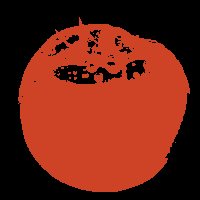

,sec1_mean,sec1_std,sec2_mean,sec2_std,sec3_mean,sec3_std,sec4_mean,sec4_std,sec5_mean,sec5_std,sec6_mean,sec6_std,sec7_mean,sec7_std,sec8_mean,sec8_std,sec9_mean,sec9_std,sec10_mean,sec10_std,sec11_mean,sec11_std,sec12_mean,sec12_std,sec13_mean,sec13_std,sec14_mean,sec14_std,sec15_mean,sec15_std,sec16_mean,sec16_std,sec17_mean,sec17_std,sec18_mean,sec18_std,sec19_mean,sec19_std,sec20_mean,sec20_std,sec21_mean,sec21_std,sec22_mean,sec22_std,sec23_mean,sec23_std,sec24_mean,sec24_std,sec25_mean,sec25_std
0,0.0,0.0,17.825,49.556426,35.84375,65.517273,10.139583,38.404531,0.0,0.0,22.797917,55.02373,74.722917,77.739125,76.789583,77.793438,82.666667,77.647637,41.26875,68.689939,52.247917,73.484223,101.072917,74.237533,98.61875,74.962788,103.333333,73.49074,69.297917,77.334045,35.908333,65.558587,103.333333,73.49074,103.333333,73.49074,103.333333,73.49074,36.877083,66.167627,0.710417,10.489811,51.214583,73.116726,81.310417,77.720763,60.45,75.840738,2.970833,21.294032


In [53]:
img = cv2.imread('/content/cachua.jpg')
img = cv2.resize(img, (200, 200))
img, center = clustering_image(img)
img = remove_light_color(img, center)
cv2_imshow(img)

df = create_df_with_one_img(img)
df.head()

In [54]:
for name, model in models:
  pred = model.predict(df)
  print(name, pred)

rfc ['cam']
svc ['cam']
knn ['cam']
